In [2]:
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torch.nn.functional import one_hot
from torch import Tensor
from typing import Union
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

import flwr as fl
from flwr.common import Metrics

from typing import List, Tuple

from model import *
from loss import * 
from utils import show_metrics,clean_data,train,train_roc,back_prob,test,load_data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
!pip install -q flwr[simulation] torch torchvision matplotlib

In [25]:
device = torch.device("cuda")

In [18]:
train_data_path="/kaggle/input/ecc-train-and-test/ecc_train.csv"
test_data_path="/kaggle/input/ecc-train-and-test/ecc_test.csv"
train_target="Class"
test_target="Class"
train_drop=['Class','Time','Unnamed: 0']
test_drop=['Class','Time','Unnamed: 0']
batch_size=32
train_dl,input_shape,y_train=load_data(train_data_path,train_target,train_drop,batch_size)
test_dl,_,_=load_data(test_data_path,test_target,test_drop,batch_size)

In [28]:
model=Net(input_shape).to(device)
optimizer=torch.optim.SGD(model.parameters(), lr=.01, momentum=.9)
loss_func=Focal_Loss(2)

In [32]:
train(model, train_dl, loss_func, optimizer)

100%|██████████| 1/1 [00:26<00:00, 26.71s/it]


f1_score =  0.68
roc_auc_score =  0.8205260611257831
average_precision_score 0.46473778918714115
Precision :  0.723404255319149
Recall :  0.6415094339622641
accuracy_score :  0.998876404494382
tn 56828 fp 26 fn 38 tp 68


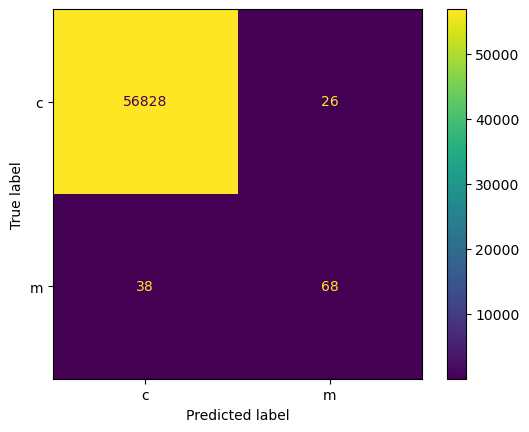

In [43]:
test(model, test_dl)

In [46]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [49]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [50]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)


In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-29 01:36:03,250 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-29 01:36:06,358	ERROR services.py:1207 -- Failed to start the dashboard , return code -11
2023-07-29 01:36:06,360	ERROR services.py:1232 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2023-07-29 01:36:06,363	ERROR services.py:1276 -- 
The last 20 lines of /tmp/ray/session_2023-07-29_01-36-03_278782_28/logs/dashboard.log (it contains the error message from the dashboard): 
2023-07-29 01:36:06,277	INFO head.py:242 -- Starting dashboard metrics server on port 44227

2023-07-29 01:36:06,610	INFO worker.py:1636 -- Started a local Ray instance.


In [3]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}